# SIMPLE BACKPROPAGATION MODEL

In [1]:
# from Karpathies micrograd engine. 

import math

class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [3]:
# example 1: 1 -> 0

w1 = Value(0.8,label='w1')
w2 = Value(-0.6,label='w2')
b1 = Value(0.9,label='b1')
b2 = Value(0.2,label='b2')
x1 = Value(1.0,label='x1')
x2 = Value(0.0,label='x2')


x1w1 = x1*w1 ; x1w1.label = 'x1w1'

x1w1b1 = x1w1 + b1 ; x1w1b1.label = 'x1w1b1'

x1w1b1w2 = x1w1b1 * w2 ;  x1w1b1w2.label = 'x1w1b1w2'

x1w1b1w2b2 = x1w1b1w2 + b2; x1w1b1w2b2.label = 'x1w1b1w2b2'


In [4]:
# input 2: 0 -> 1

x2 = Value(0.0,label='x2')


x2w1 = x2*w1 ; x2w1.label = 'x2w1'

x2w1b1 = x2w1 + b1 ; x2w1b1.label = 'x2w1b1'

x2w1b1w2 = x2w1b1 * w2 ;  x2w1b1w2.label = 'x2w1b1w2'

x2w1b1w2b2 = x2w1b1w2 + b2; x2w1b1w2b2.label = 'x2w1b1w2b2'



In [5]:
# these are the expected outputs

y_real_1= Value(0.0,label = 'y_real_1')
y_real_2 = Value(1.0,label = 'y_real_2')

In [6]:
# this is the loss funtion of input 1! I used mean squared error

loss1 = (x1w1b1w2b2 - y_real_1) **2 ; loss1.label = 'loss1'


In [7]:
# this is the loss funtion of input 2, again with mean squared error:

loss2 = (x2w1b1w2b2 - y_real_2) **2 ; loss2.label = 'loss2'


In [8]:
# the total loss is just a sum of the losses

total_loss = loss1+ loss2; total_loss.label = 'total_loss'

In [9]:
# this is the gradient of the sum of the loss functions with respect to the the weights and all the other parameters

total_loss.backward()

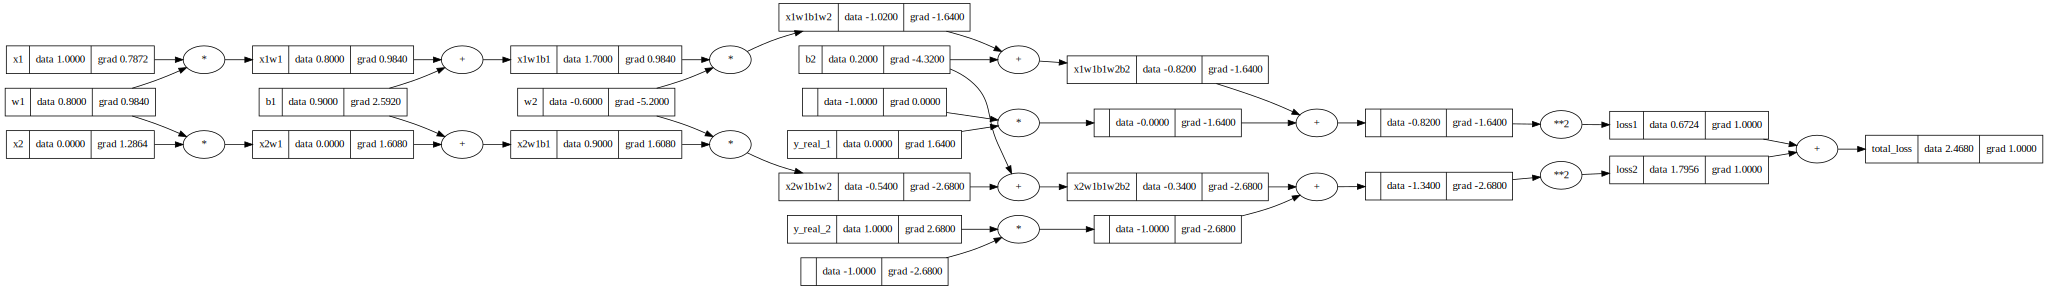

In [10]:
draw_dot(total_loss)

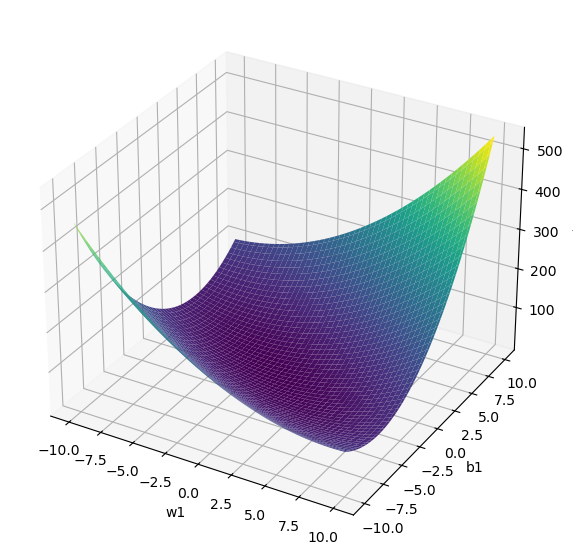

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define your function in terms of w1, w2, b1, b2
def func(w1,b1,w2=1,b2=1):
    # Example function; modify to match your actual function
    return (w2*b1+b2-1)**2 + (w2*w1 + w2*b1 + b2)**2

# Generate values for w1 and w2
w1 = np.linspace(-10, 10, 100)
b1 = np.linspace(-10, 10, 100)
w1, b1 = np.meshgrid(w1, b1)  # Create a meshgrid for 3D plotting

# Compute y values based on w1, w2, and constants b1, b2
y = func( w1,b1,w2=1,b2=1)  # Change b1 and b2 as desired

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(w1, b1, y, cmap='viridis')

# Labeling the axes
ax.set_xlabel('w1')
ax.set_ylabel('b2')
ax.set_zlabel('y')

plt.show()


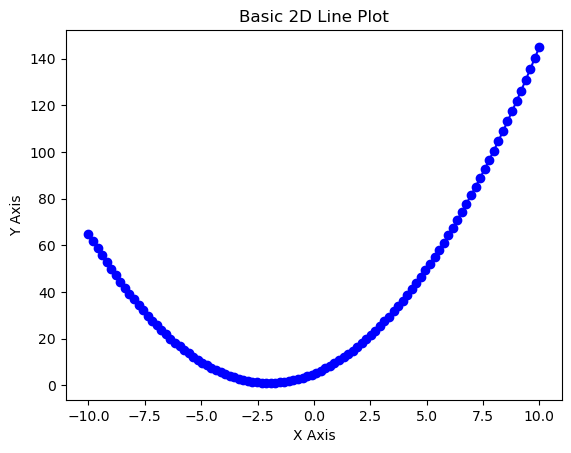

In [26]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Define your function in terms of w1, w2, b1, b2
def func(w1,b1=1,w2=1,b2=3):
    # Example function; modify to match your actual function
    return (w2*b1+b2-1)**2 + (w2*w1 + w2*b1 + b2)**2

# Generate values for w1 and w2
w1 = np.linspace(-10, 10, 100)
# b1 = np.linspace(-10, 10, 100)
# w1, b1 = np.meshgrid(w1, b1)  # Create a meshgrid for 3D plotting

# Compute y values based on w1, w2, and constants b1, b2
y = func( w1,b1=1,w2=1,b2=1)  # Change b1 and b2 as desired

# Plot
# Create plot
plt.plot(w1, y, label='Line', color='blue', marker='o')

# Add labels and title
plt.xlabel('X Axis')
plt.ylabel('Y Axis')
plt.title('Basic 2D Line Plot')


plt.show()


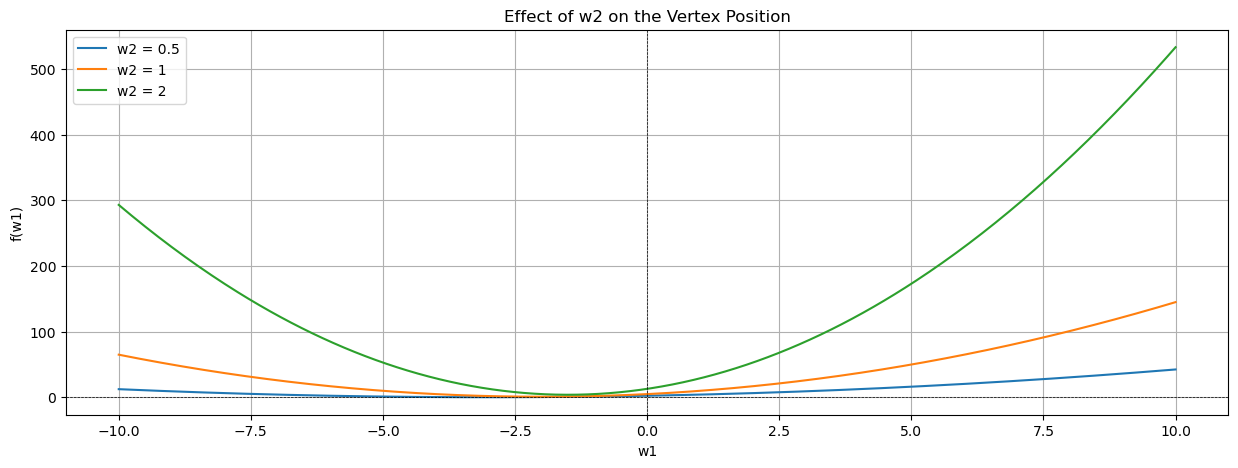

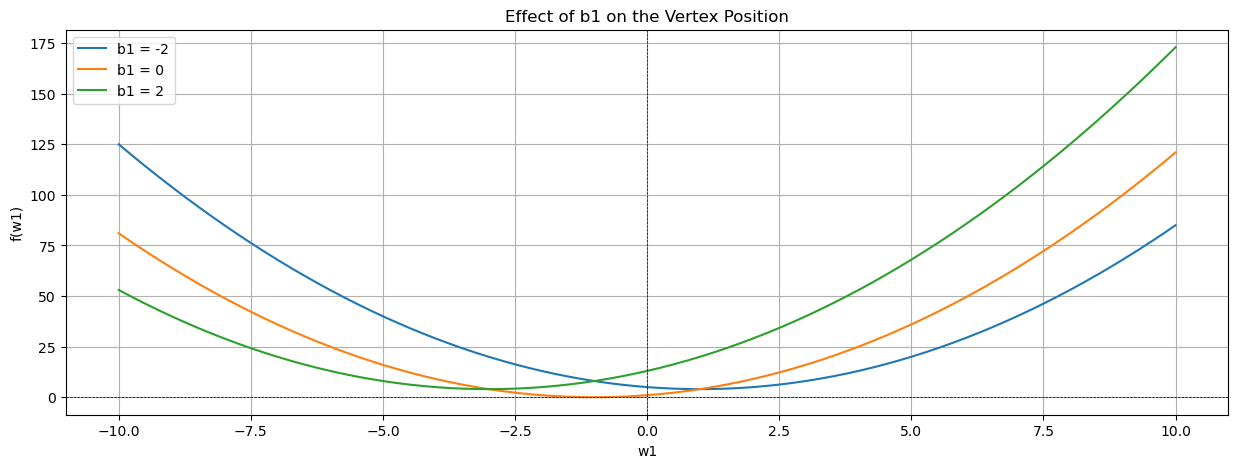

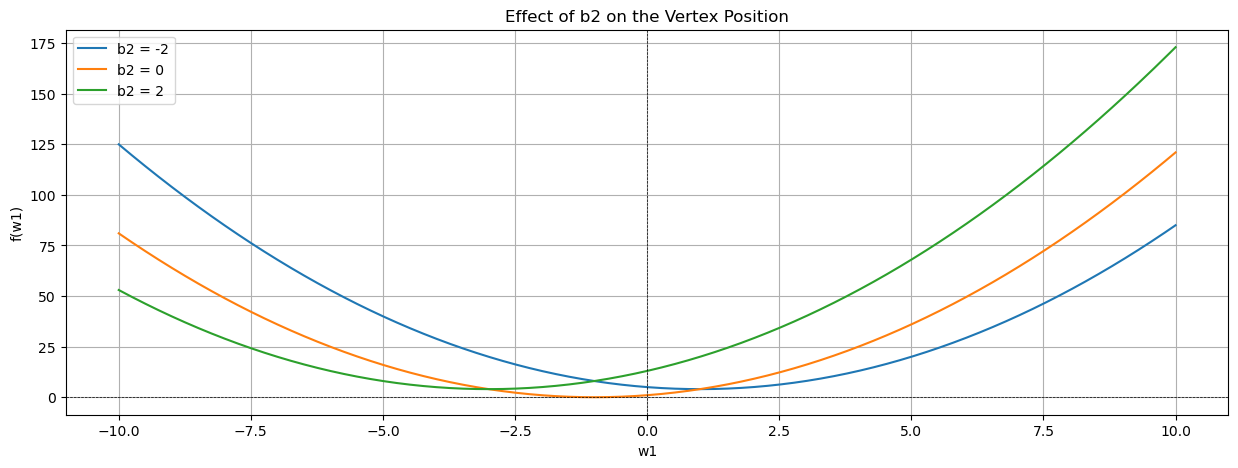

In [27]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(w1, w2, b1, b2):
    return (w2 * b1 + b2 - 1)**2 + (w2 * w1 + w2 * b1 + b2)**2

# Range of w1 values
w1_values = np.linspace(-10, 10, 400)

# Plot 1: Varying w2
plt.figure(figsize=(15, 5))

w2_values = [0.5, 1, 2]  # Different w2 values
b1 = 1
b2 = 1

for w2 in w2_values:
    plt.plot(w1_values, f(w1_values, w2, b1, b2), label=f'w2 = {w2}')

plt.title('Effect of w2 on the Vertex Position')
plt.xlabel('w1')
plt.ylabel('f(w1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

# Plot 2: Varying b1
plt.figure(figsize=(15, 5))

b1_values = [-2, 0, 2]  # Different b1 values
w2 = 1
b2 = 1

for b1 in b1_values:
    plt.plot(w1_values, f(w1_values, w2, b1, b2), label=f'b1 = {b1}')

plt.title('Effect of b1 on the Vertex Position')
plt.xlabel('w1')
plt.ylabel('f(w1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

# Plot 3: Varying b2
plt.figure(figsize=(15, 5))

b2_values = [-2, 0, 2]  # Different b2 values
w2 = 1
b1 = 1

for b2 in b2_values:
    plt.plot(w1_values, f(w1_values, w2, b1, b2), label=f'b2 = {b2}')

plt.title('Effect of b2 on the Vertex Position')
plt.xlabel('w1')
plt.ylabel('f(w1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()


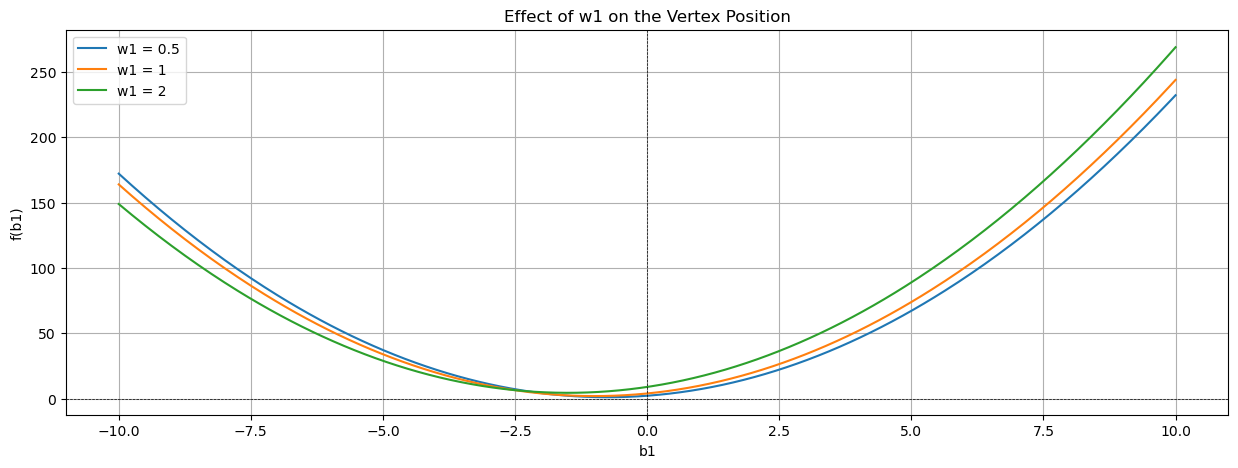

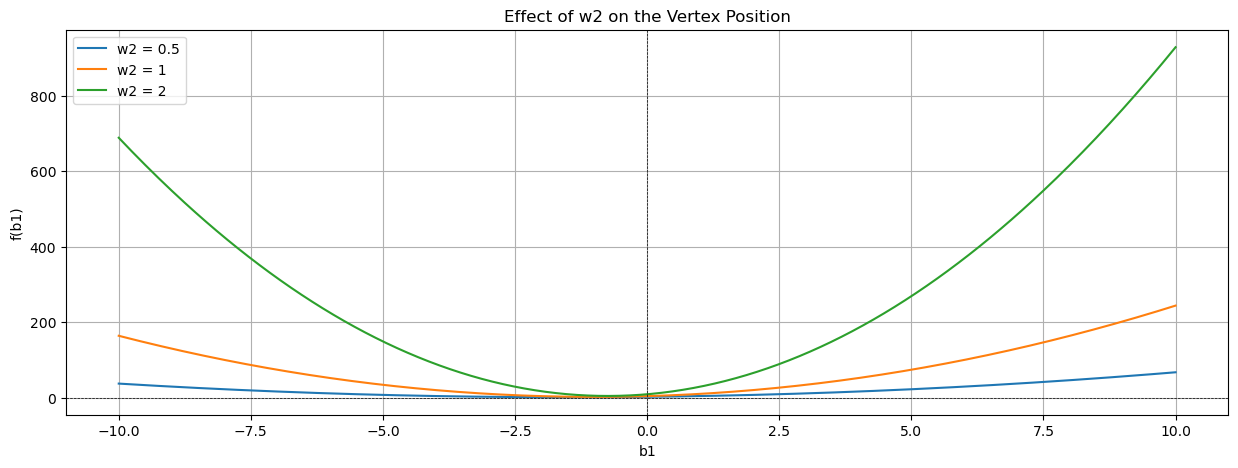

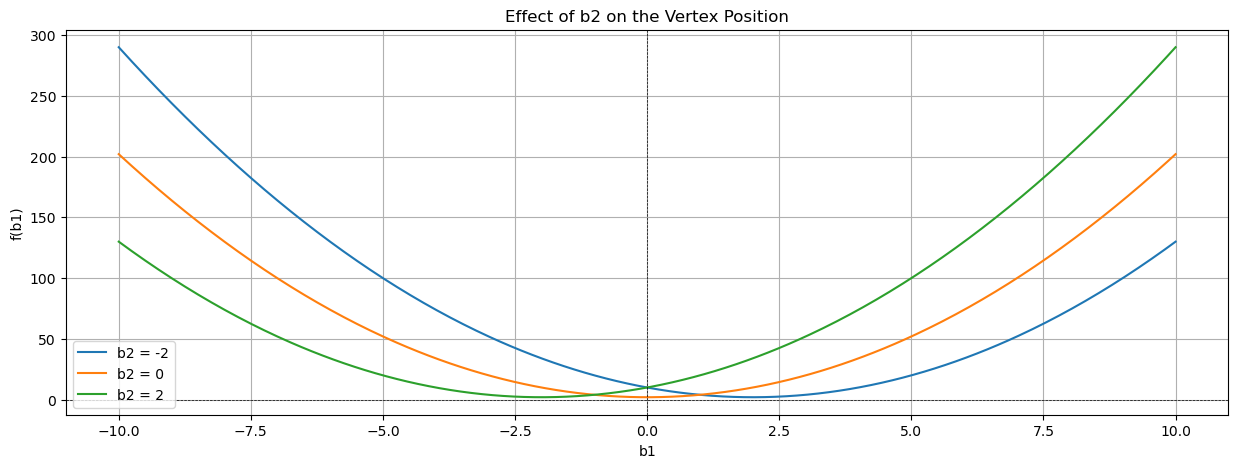

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(w1, w2, b1, b2):
    return (w2 * b1 + b2 - 1)**2 + (w2 * w1 + w2 * b1 + b2)**2

# Range of w1 values
b1_values = np.linspace(-10, 10, 400)

# Plot 1: Varying w1
plt.figure(figsize=(15, 5))

w1_values = [0.5, 1, 2]  # Different w2 values
w2 = 1
b2 = 1

for w1 in w1_values:
    plt.plot(b1_values, f(w1, w2, b1_values, b2), label=f'w1 = {w1}')

plt.title('Effect of w1 on the Vertex Position')
plt.xlabel('b1')
plt.ylabel('f(b1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

# Plot 1: Varying w2
plt.figure(figsize=(15, 5))

w2_values = [0.5, 1, 2]  # Different w2 values
w1 = 1
b2 = 1

for w2 in w2_values:
    plt.plot(b1_values, f(w1, w2, b1_values, b2), label=f'w2 = {w2}')

plt.title('Effect of w2 on the Vertex Position')
plt.xlabel('b1')
plt.ylabel('f(b1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()






# Plot 3: Varying b2
plt.figure(figsize=(15, 5))

b2_values = [-2, 0, 2]  # Different b2 values
w2 = 1
w1 = 1

for b2 in b2_values:
    plt.plot(b1_values, f(w1, w2, b1_values, b2), label=f'b2 = {b2}')

plt.title('Effect of b2 on the Vertex Position')
plt.xlabel('b1')
plt.ylabel('f(b1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()


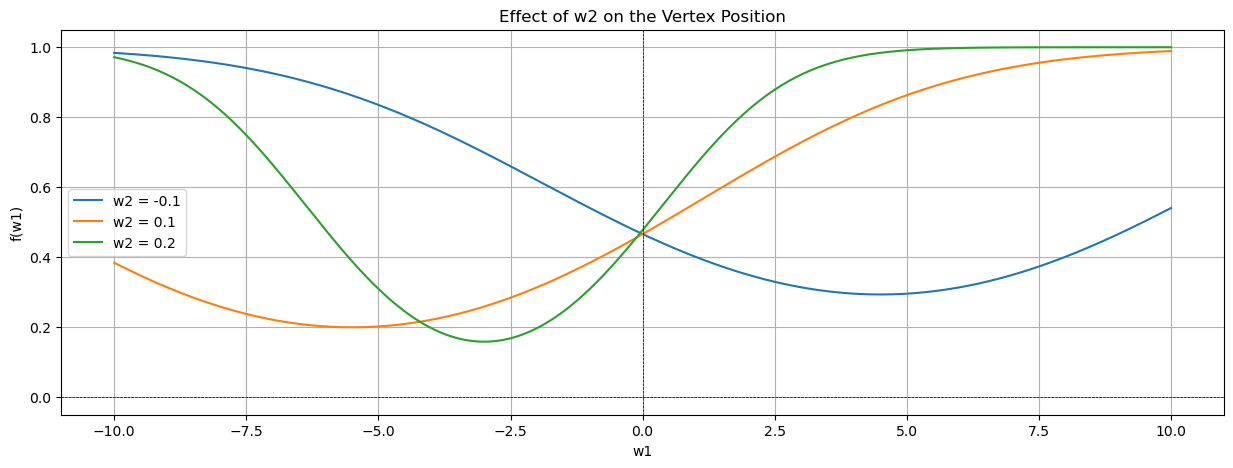

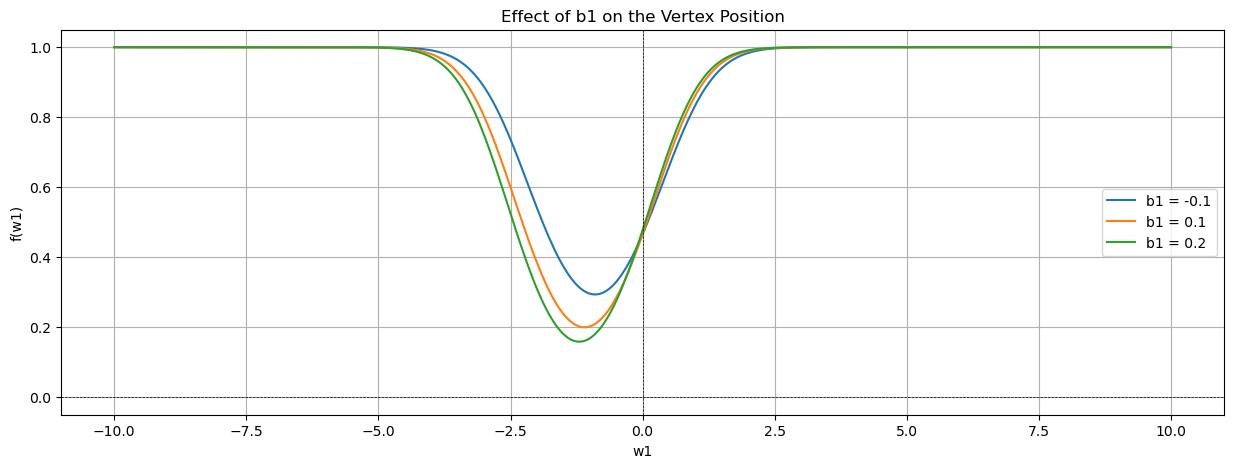

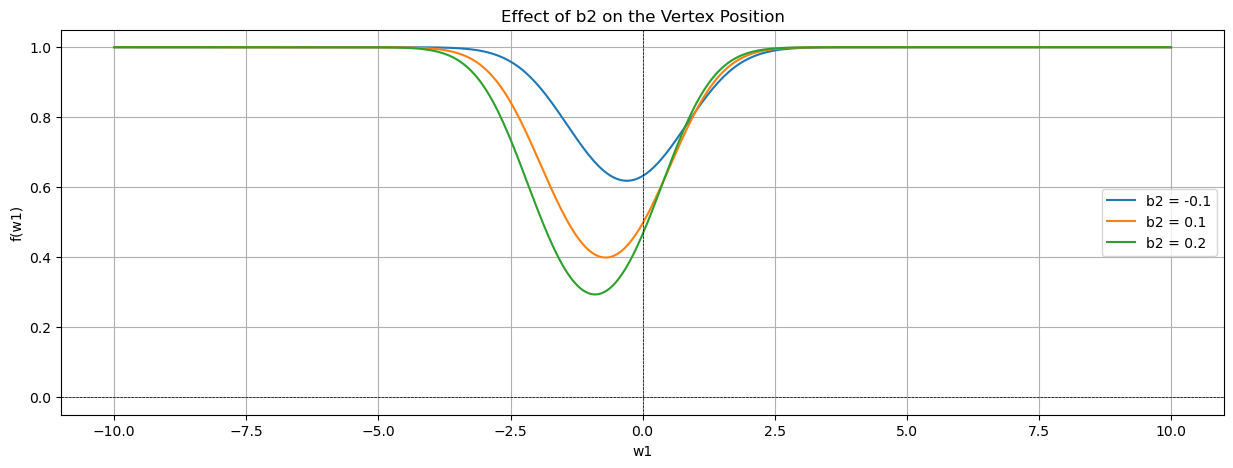

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import math

# Define the function
def f(w1, w2, b1, b2):
    return np.tanh((w2 * b1 + b2 - 1)**2 + (w2 * w1 + w2 * b1 + b2)**2)

# Range of w1 values
w1_values = np.linspace(-10, 10, 400)

# Plot 1: Varying w2
plt.figure(figsize=(15, 5))

w2_values = [-0.1,0.1,0.2]  # Different w2 values
b1 = 0.5
b2 = 0.5

for w2 in w2_values:
    plt.plot(w1_values, f(w1_values, w2, b1, b2), label=f'w2 = {w2}')

plt.title('Effect of w2 on the Vertex Position')
plt.xlabel('w1')
plt.ylabel('f(w1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

# Plot 2: Varying b1
plt.figure(figsize=(15, 5))

b1_values = [-0.1, 0.1, 0.2]  # Different b1 values
w2 = 0.5
b2 = 0.5

for b1 in b1_values:
    plt.plot(w1_values, f(w1_values, w2, b1, b2), label=f'b1 = {b1}')

plt.title('Effect of b1 on the Vertex Position')
plt.xlabel('w1')
plt.ylabel('f(w1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

# Plot 3: Varying b2
plt.figure(figsize=(15, 5))

b2_values = [-0.1, 0.1, 0.2]  # Different b2 values
w2 = 0.5
b1 = 0.5

for b2 in b2_values:
    plt.plot(w1_values, f(w1_values, w2, b1, b2), label=f'b2 = {b2}')

plt.title('Effect of b2 on the Vertex Position')
plt.xlabel('w1')
plt.ylabel('f(w1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()


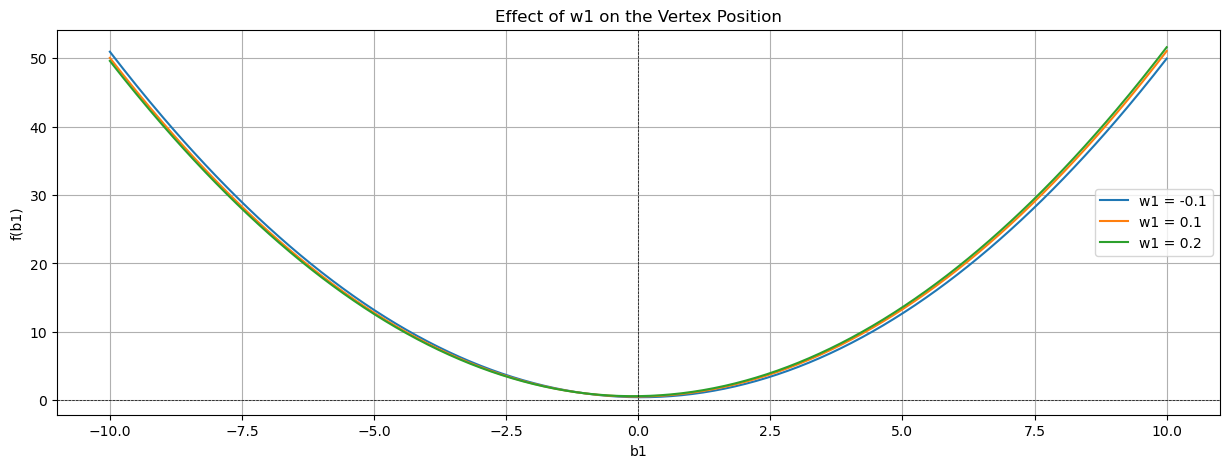

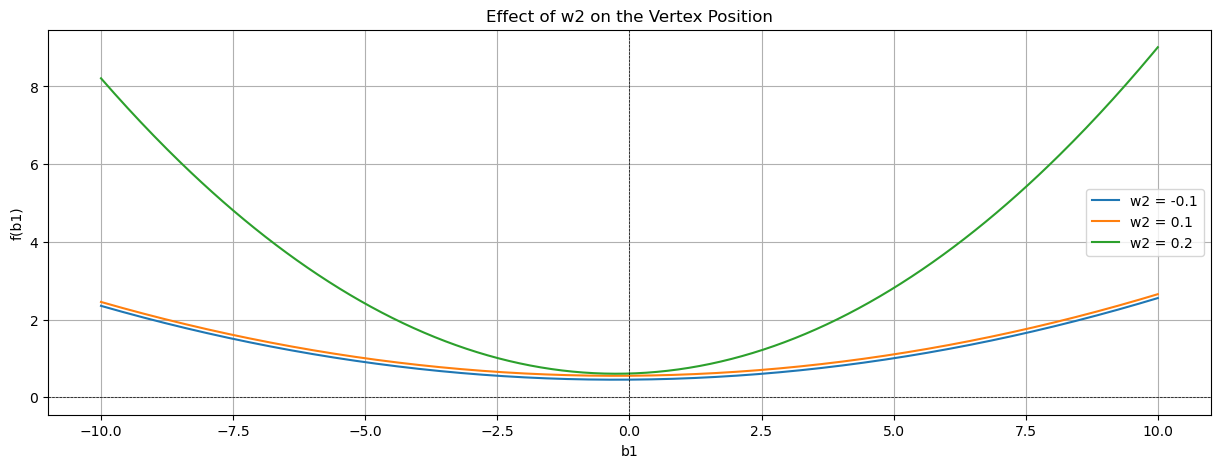

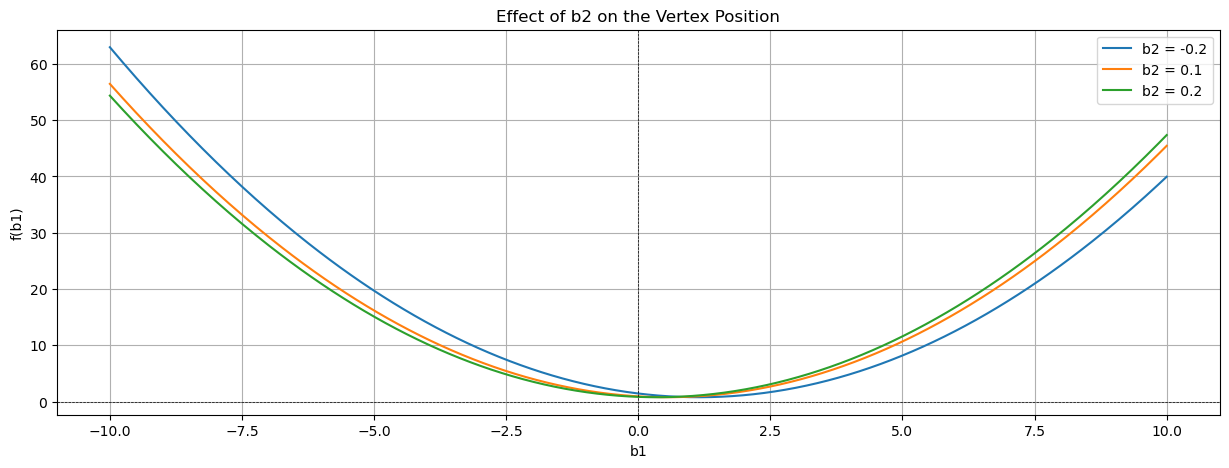

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Define the function
def f(w1, w2, b1, b2):
    return (w2 * b1 + b2 - 1)**2 + (w2 * w1 + w2 * b1 + b2)**2

# Range of w1 values
b1_values = np.linspace(-10, 10, 400)

# Plot 1: Varying w1
plt.figure(figsize=(15, 5))

w1_values = [-0.1, 0.1, 0.2]  # Different w2 values
w2 = 0.5
b2 = 0.5

for w1 in w1_values:
    plt.plot(b1_values, f(w1, w2, b1_values, b2), label=f'w1 = {w1}')

plt.title('Effect of w1 on the Vertex Position')
plt.xlabel('b1')
plt.ylabel('f(b1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()

# Plot 1: Varying w2
plt.figure(figsize=(15, 5))

w2_values = [-0.1, 0.1, 0.2]  # Different w2 values
w1 = 0.5
b2 = 0.5

for w2 in w2_values:
    plt.plot(b1_values, f(w1, w2, b1_values, b2), label=f'w2 = {w2}')

plt.title('Effect of w2 on the Vertex Position')
plt.xlabel('b1')
plt.ylabel('f(b1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()






# Plot 3: Varying b2
plt.figure(figsize=(15, 5))

b2_values = [-0.2, 0.1, 0.2]  # Different b2 values
w2 = 0.5
w1 = 0.5

for b2 in b2_values:
    plt.plot(b1_values, f(w1, w2, b1_values, b2), label=f'b2 = {b2}')

plt.title('Effect of b2 on the Vertex Position')
plt.xlabel('b1')
plt.ylabel('f(b1)')
plt.axhline(0, color='black', lw=0.5, ls='--')
plt.axvline(0, color='black', lw=0.5, ls='--')
plt.legend()
plt.grid()
plt.show()
